# SOSE Data
Bottom Temperature and Salinity to compare with ECCOv4r3 and WOA products

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.3:33175")
client

Client Scheduler: tcp://10.32.16.3:33175 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 26 Cores: 52 Memory: 299.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
ocean_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ocean_cat = intake.Catalog(ocean_url)
ds = ocean_cat["SOSE"].to_dask()

In [6]:
coords = ds.coords.to_dataset().reset_coords().roll(XC=700, XG=700) #ds split into coords
dsr = ds.reset_coords(drop=True).roll(XC=700, XG=700) #ds dropping coords so it just holds data variables

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  """Entry point for launching an IPython kernel.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/dataarray.py:2793: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


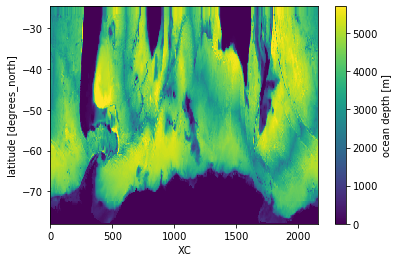

In [5]:
#checking to see if `roll` worked
coords.Depth.roll(XC=700).drop('XC').plot()

In [43]:
dsr.XC

<xarray.DataArray 'XC' (XC: 2160)>
array([8.333334e-02, 2.500000e-01, 4.166667e-01, ..., 3.595833e+02,
       3.597500e+02, 3.599167e+02], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
Attributes:
    axis:           X
    coordinate:     YC XC
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [ ]:
coords.Depth.drop('XC').plot()

In [11]:
coords.XC.isel(XC=-65, method='nearest')

ValueError: index must be monotonic increasing or decreasing

In [7]:
sst_mean = dsr.THETA.isel(Z=0).mean(dim='time')

In [64]:
surface_mask = (coords.hFacC[0]>0).load()

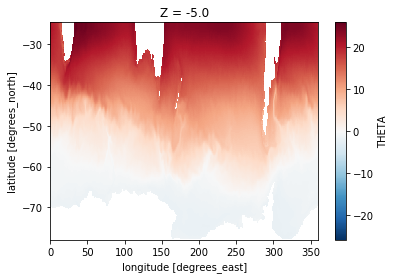

In [9]:
sst_mean.where(surface_mask).plot()

In [49]:
ds.XC[180]

<xarray.DataArray 'XC' ()>
array(30.083334, dtype=float32)
Coordinates:
    XC       float32 30.083334
Attributes:
    axis:           X
    coordinate:     YC XC
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [50]:
ds.XC[179]

<xarray.DataArray 'XC' ()>
array(29.916668, dtype=float32)
Coordinates:
    XC       float32 29.916668
Attributes:
    axis:           X
    coordinate:     YC XC
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

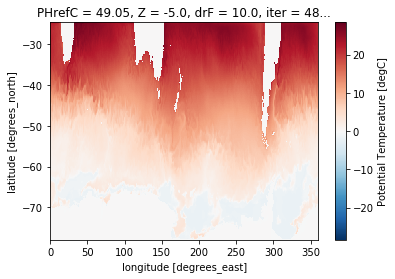

In [68]:
ds.THETA[0,0].plot()

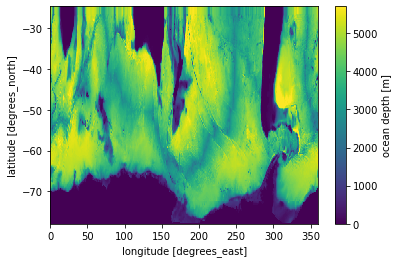

In [84]:
ds.Depth.plot()

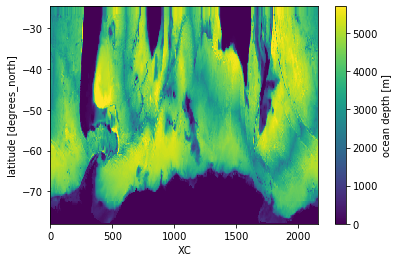

In [83]:
ds.Depth.roll(XC=700, roll_coords=True).drop('XC').plot()

In [19]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 95
left_lon =  310
right_lon = 880

In [20]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [22]:
dsr = dsr.drop(['XC', 'YC', 'XG', 'YG'])
coords = coords.drop(['XC', 'YC', 'XG', 'YG'])

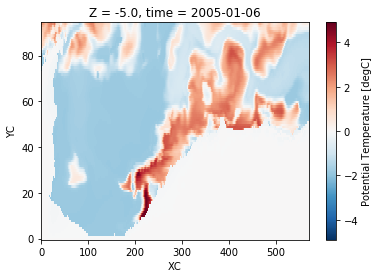

In [23]:
dsr.THETA[0,0].isel(**lat_range, **lon_range).plot()#.drop(['XC', 'YC']).plot()

In [11]:
temp_wg = dsr.THETA.isel(**lat_range, **lon_range)

In [12]:
temp_wg_mean = temp_wg.mean(dim='time')
temp_wg_mean

<xarray.DataArray 'THETA' (Z: 42, YC: 95, XC: 371)>
dask.array<mean_agg-aggregate, shape=(42, 95, 371), dtype=float32, chunksize=(42, 95, 371), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 298.08334 298.25 298.4167 ... 359.58334 359.75
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0

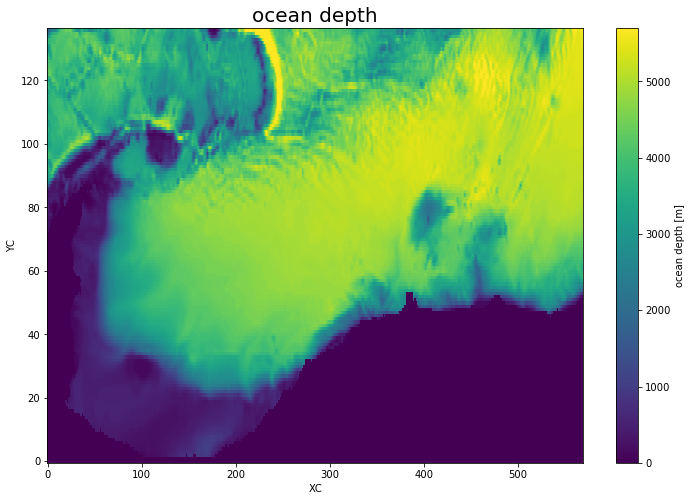

In [57]:
coords.Depth.isel(**lat_range, **lon_range).plot(figsize=(12,8))
plt.title('ocean depth', fontsize=20);

In [13]:
#this gives us the depth of the bottom cell
depth_max = dsr.Z.where(temp_wg_mean.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [14]:
depth_max

<xarray.DataArray 'Z' (YC: 95, XC: 371)>
dask.array<nanmax-aggregate, shape=(95, 371), dtype=float32, chunksize=(95, 371), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 298.08334 298.25 298.4167 ... 359.58334 359.75
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083

In [15]:
bottom_temp = temp_wg_mean.sel(Z=depth_max.fillna(0.))

In [17]:
bottom_temp.load()

<xarray.DataArray 'THETA' (YC: 95, XC: 371)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.01892178, -0.02198935, -0.02457149, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02469273, -0.028699  , -0.03207249, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.04170532, -0.0534445 , -0.07498712, ..., -0.85031897,
        -0.85095733, -0.851702  ],
       [ 0.0340001 ,  0.02583928,  0.00944502, ..., -0.850756  ,
        -0.8522474 , -0.853986  ],
       [ 0.08779269,  0.0855999 ,  0.07734483, ..., -0.8494363 ,
        -0.85166365, -0.85396403]], dtype=float32)
Coordinates:
  * XC       (XC) float32 298.08334 298.25 298.4167 ... 359.58334 359.75
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0

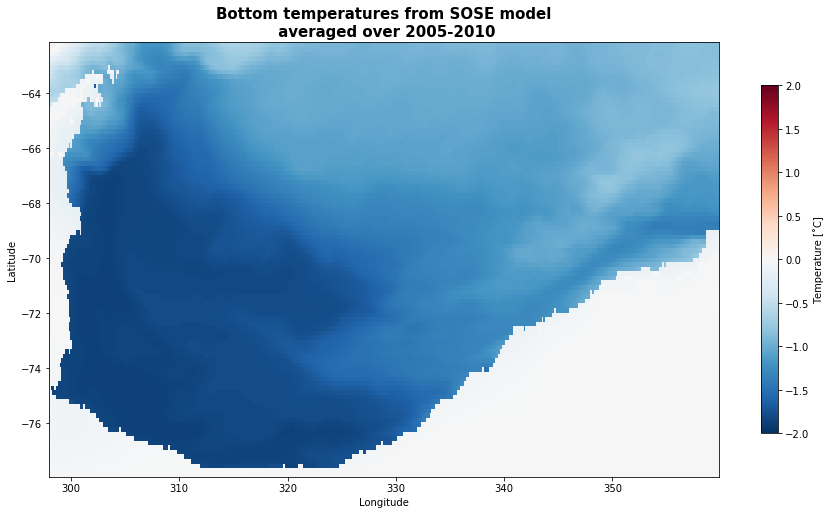

In [18]:
bottom_temp.plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'}, cmap='RdBu_r', vmax=2)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from SOSE model\n averaged over 2005-2010', fontsize=15, weight='bold');

In [19]:
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0).load()

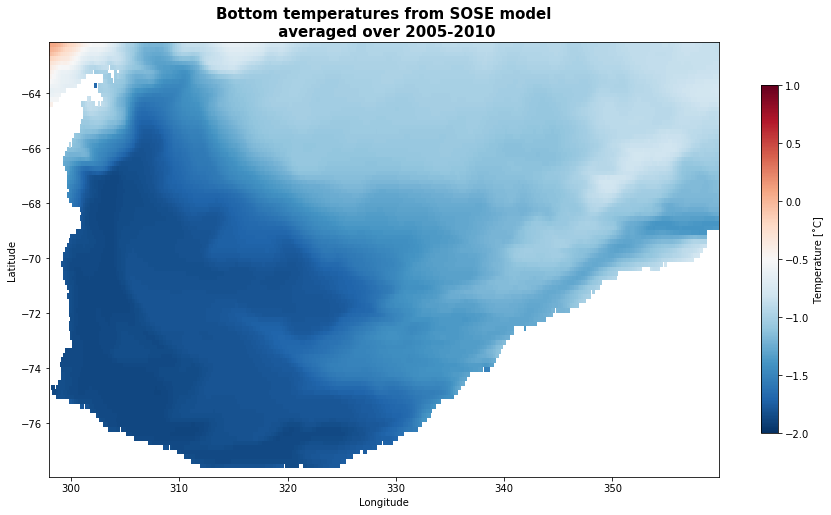

In [24]:
bottom_temp.where(surface_mask).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'}, cmap='RdBu_r', vmin=-2, vmax=1)

#plt.xticks(labels=(-65, -50, -35, -20, -5, 25))
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from SOSE model\n averaged over 2005-2010', fontsize=15, weight='bold');

## BOTTOM SALT

In [25]:
slt_wg = dsr.SALT.isel(**lat_range, **lon_range)

In [26]:
slt_wg_mean = slt_wg.mean(dim='time')
slt_wg_mean

<xarray.DataArray 'SALT' (Z: 42, YC: 95, XC: 371)>
dask.array<mean_agg-aggregate, shape=(42, 95, 371), dtype=float32, chunksize=(42, 95, 371), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 298.08334 298.25 298.4167 ... 359.58334 359.75
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0

In [27]:
#this gives us the depth of the bottom cell
depth_max_slt = dsr.Z.where(slt_wg_mean.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [28]:
bottom_slt = slt_wg_mean.sel(Z=depth_max_slt.fillna(0.)).load()

In [29]:
bottom_slt

<xarray.DataArray 'SALT' (YC: 95, XC: 371)>
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.8910041e-03, 3.3693200e-03, 3.7768013e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.7561858e-03, 4.3765693e-03, 4.9043889e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [3.3550003e+01, 3.3549782e+01, 3.3552044e+01, ..., 3.4040676e+01,
        3.4039837e+01, 3.4038883e+01],
       [3.3549767e+01, 3.3548813e+01, 3.3551174e+01, ..., 3.4050510e+01,
        3.4049866e+01, 3.4049076e+01],
       [3.3560589e+01, 3.3557846e+01, 3.3557991e+01, ..., 3.4058571e+01,
        3.4058079e+01, 3.4057457e+01]], dtype=float32)
Coordinates:
  * XC       (XC) float32 298.08334 298.25 298.4167 ... 359.58334 359.75
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0

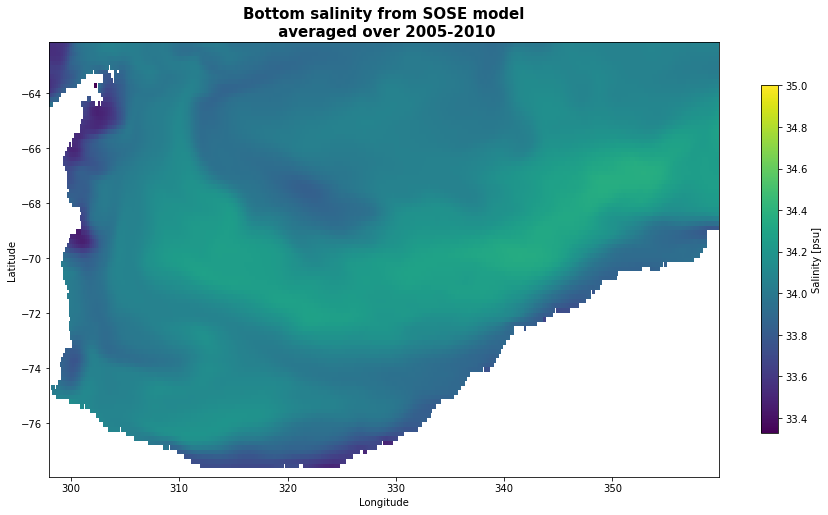

In [30]:
bottom_slt.where(surface_mask).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Salinity [psu]'}, vmax=35)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom salinity from SOSE model\n averaged over 2005-2010', fontsize=15, weight='bold');